In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



random.seed(2)  # Set the seed for Python's random module
np.random.seed(3)  # Set the seed for numpy's random module

In [2]:
from cabm import cabm_model

In [3]:
model = cabm_model.ConsumerModel(1000, "config.toml", enable_ads=True, enable_pricepoint=True)

/Users/michael/Documents/github/consumer-abm/cabm/ad_calendar.py:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/Users/michael/Documents/github/consumer-abm/cabm/ad_calendar.py:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/Users/michael/.venvs/pydev/lib/python3.12/site-packages/mesa/time.py:82: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, s

In [4]:
for i in range(104):
    model.step()

In [5]:
model_df = model.datacollector.get_model_vars_dataframe()

#model run for 2 52 week cycles to let dynamics settle
model_df = model_df.loc[52:]

In [6]:
# Prep joint calendar for plotting
joint_calendar_df = model.config.joint_calendar

joint_calendar_df['TV_A'] = joint_calendar_df[('A', 'TV')]
joint_calendar_df['Web_A'] = joint_calendar_df[('A', 'Web')]
joint_calendar_df['TV_B'] = joint_calendar_df[('B', 'TV')]
joint_calendar_df['Web_B'] = joint_calendar_df[('B', 'Web')]

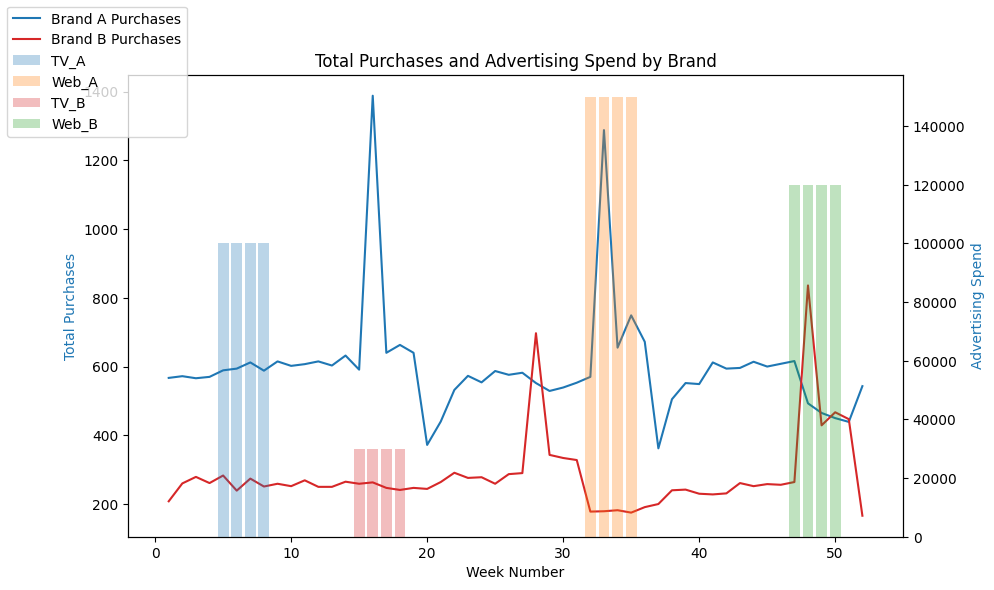

In [7]:

# Extract purchases by brand
model_df['Total_Purchases_A'] = model_df['Total_Purchases'].apply(lambda x: x['A'])
model_df['Total_Purchases_B'] = model_df['Total_Purchases'].apply(lambda x: x['B'])
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot total purchases for brand A
color = 'tab:blue'
ax1.set_ylabel('Total Purchases', color=color)
ax1.plot(model_df['Week_Number'], model_df['Total_Purchases_A'], color=color, label='Brand A Purchases')

# Plot total purchases for brand B
color = 'tab:red'
ax1.plot(model_df['Week_Number'], model_df['Total_Purchases_B'], color=color, label='Brand B Purchases')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot advertising campaigns for brand A with increased transparency
color = 'tab:blue'
ax2.set_ylabel('Advertising Spend', color=color)
ax2.bar(joint_calendar_df.index, joint_calendar_df['TV_A'], color=color, label='TV_A', alpha=0.3)
ax2.bar(joint_calendar_df.index, joint_calendar_df['Web_A'], bottom=joint_calendar_df['TV_A'], color='tab:orange', label='Web_A', alpha=0.3)

# Plot advertising campaigns for brand B with increased transparency
color = 'tab:red'
ax2.bar(joint_calendar_df.index, joint_calendar_df['TV_B'], color=color, label='TV_B', alpha=0.3)
ax2.bar(joint_calendar_df.index, joint_calendar_df['Web_B'], bottom=joint_calendar_df['TV_B'], color='tab:green', label='Web_B', alpha=0.3)

# Set the x-axis label
ax1.set_xlabel('Week Number')

# Add a title to the plot
plt.title('Total Purchases and Advertising Spend by Brand')

# Add a legend to the plot
fig.legend(loc='upper left')

# Show the plot
plt.show()

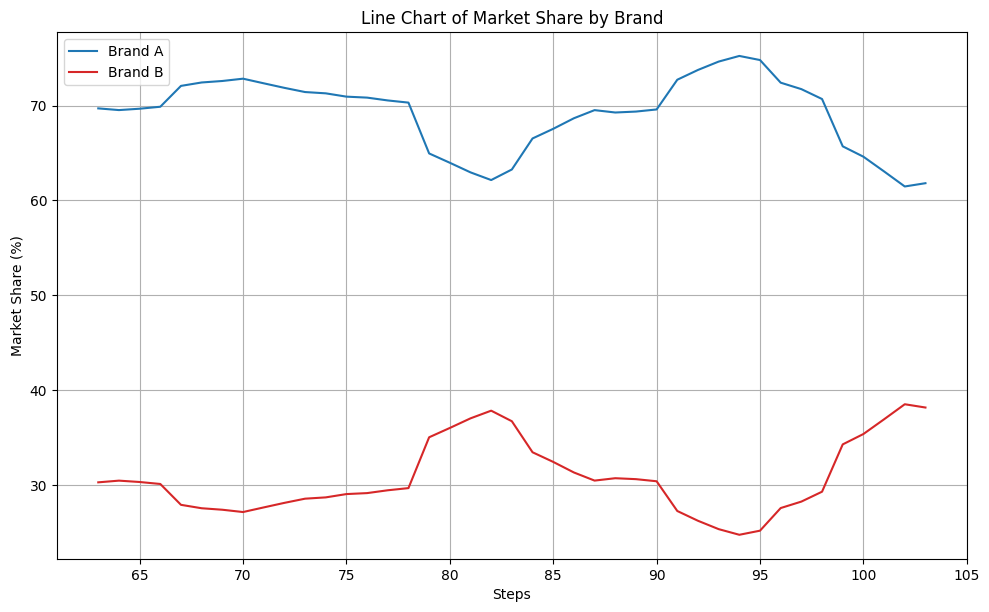

In [8]:

# Compute the quarterly average for each brand
model_df['Monthly_Average_A'] = model_df['Total_Purchases_A'].rolling(window=12).mean()
model_df['Monthly_Average_B'] = model_df['Total_Purchases_B'].rolling(window=12).mean()

# Compute the total monthly average
model_df['Total_Monthly_Average'] = model_df['Monthly_Average_A'] + model_df['Monthly_Average_B']

# Compute the market share percentage for each brand
model_df['Market_Share_A'] = (model_df['Monthly_Average_A'] / model_df['Total_Monthly_Average']) * 100
model_df['Market_Share_B'] = (model_df['Monthly_Average_B'] / model_df['Total_Monthly_Average']) * 100

fig, ax2 = plt.subplots(figsize=(10,6))
ax2.set_ylabel('Market Share (%)')
ax2.set_xlabel('Steps')

# Plot market share for brand A
color = 'tab:blue'
ax2.plot(model_df['Market_Share_A'], color=color, label='Brand A')

# Plot market share for brand B
color = 'tab:red'
ax2.plot(model_df['Market_Share_B'], color=color, label='Brand B')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Line Chart of Market Share by Brand')
plt.grid(True)
plt.legend(loc='upper left')  # Add legend to the plot
plt.show()



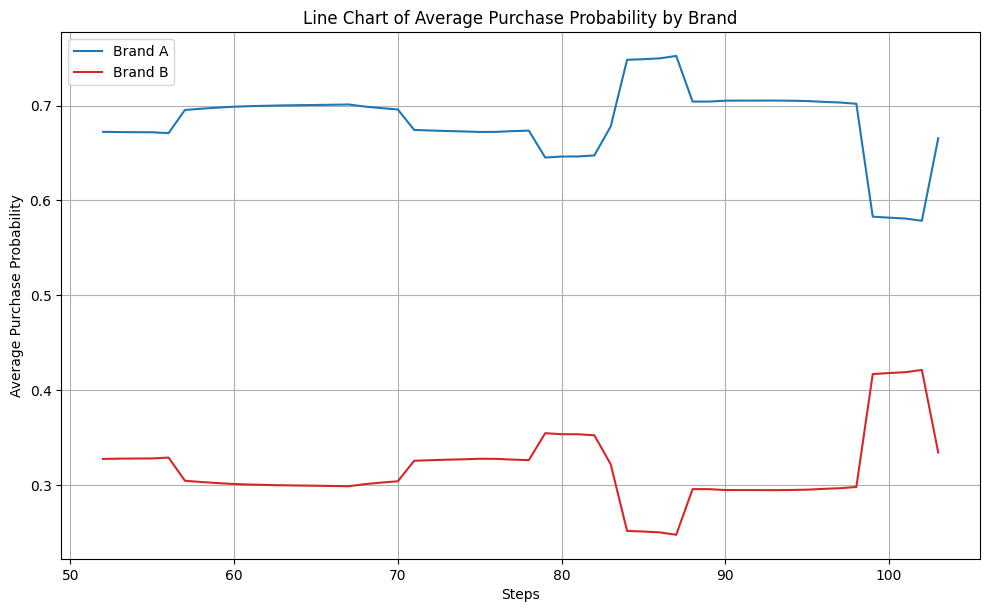

In [9]:
# Extract average purchase probabilities from the model data
model_df['Average_Purchase_Probability_A'] = model_df['Average_Purchase_Probability'].apply(lambda x: x['A'])
model_df['Average_Purchase_Probability_B'] = model_df['Average_Purchase_Probability'].apply(lambda x: x['B'])

fig, ax = plt.subplots(figsize=(10,6))
ax.set_ylabel('Average Purchase Probability')
ax.set_xlabel('Steps')

# Plot average purchase probability for brand A
color = 'tab:blue'
ax.plot(model_df['Average_Purchase_Probability_A'], color=color, label='Brand A')

# Plot average purchase probability for brand B
color = 'tab:red'
ax.plot(model_df['Average_Purchase_Probability_B'], color=color, label='Brand B')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Line Chart of Average Purchase Probability by Brand')
plt.grid(True)
plt.legend(loc='upper left')  # Add legend to the plot
plt.show()

In [10]:
agent_summary_df = model.datacollector.get_agent_vars_dataframe()

#model run for 2 52 week cycles to let dynamics settle
agent_summary_df = agent_summary_df.loc[52:]

In [11]:
def check_multiple_purchases(df):
    # Define a function to check if more than one value in the dictionary is greater than 0
    def more_than_one_purchase(purchases):
        return sum(value > 0 for value in purchases.values()) > 1

    # Apply the function to the 'Purchased_This_Step' column
    multiple_purchases = df['Purchased_This_Step'].apply(more_than_one_purchase)

    # Return True if there are any cases of multiple purchases, False otherwise
    return any(multiple_purchases)

# Usage:
print(check_multiple_purchases(agent_summary_df))

False


In [12]:
def count_letter_changes(series):
    # Compute the difference between consecutive letters
    letter_changes = series != series.shift()

    # Ignore the first value
    letter_changes = letter_changes.iloc[1:]

    # Sum the letter_changes series to get the number of letter changes
    change_count = letter_changes.sum()

    return change_count

In [13]:
letter_change_counts = [count_letter_changes(agent_summary_df.xs(agent_id, level='AgentID')['Brand_Choice']) for agent_id in agent_summary_df.index.get_level_values('AgentID').unique()]

In [14]:
sum(letter_change_counts)

4800

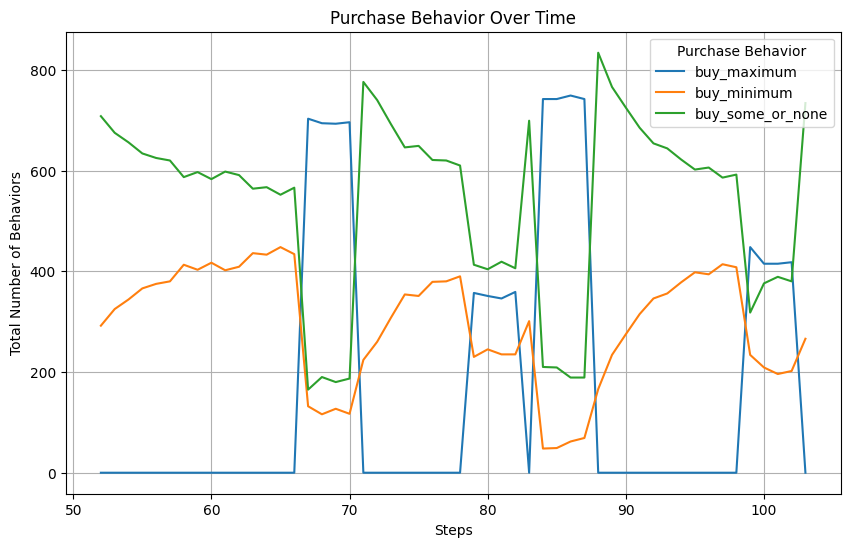

In [15]:
# Group by 'Step' and 'Purchase_Behavior' and count the occurrences
behavior_counts = agent_summary_df.groupby(['Step', 'Purchase_Behavior']).size().unstack(fill_value=0)

# Plot the behaviors over time
plt.figure(figsize=(10,6))
for behavior in behavior_counts.columns:
    plt.plot(behavior_counts.index, behavior_counts[behavior], label=behavior)

plt.title('Purchase Behavior Over Time')
plt.xlabel('Steps')
plt.ylabel('Total Number of Behaviors')
plt.legend(title='Purchase Behavior')
plt.grid(True)
plt.show()

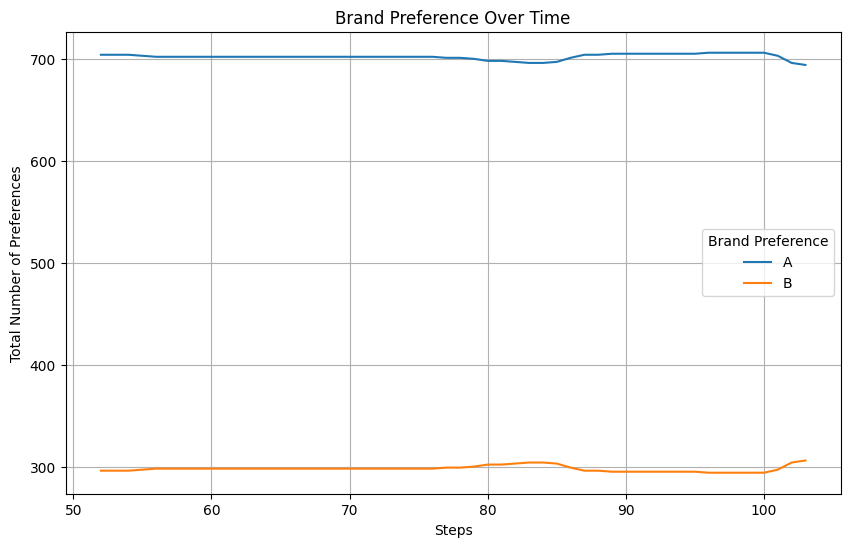

In [16]:
# Group by 'Step' and 'Brand_Preference' and count the occurrences
brand_preference_counts = agent_summary_df.groupby(['Step', 'Brand_Preference']).size().unstack(fill_value=0)

# Plot the brand preferences over time
plt.figure(figsize=(10,6))
for brand in brand_preference_counts.columns:
    plt.plot(brand_preference_counts.index, brand_preference_counts[brand], label=brand)

plt.title('Brand Preference Over Time')
plt.xlabel('Steps')
plt.ylabel('Total Number of Preferences')
plt.legend(title='Brand Preference')
plt.grid(True)
plt.show()


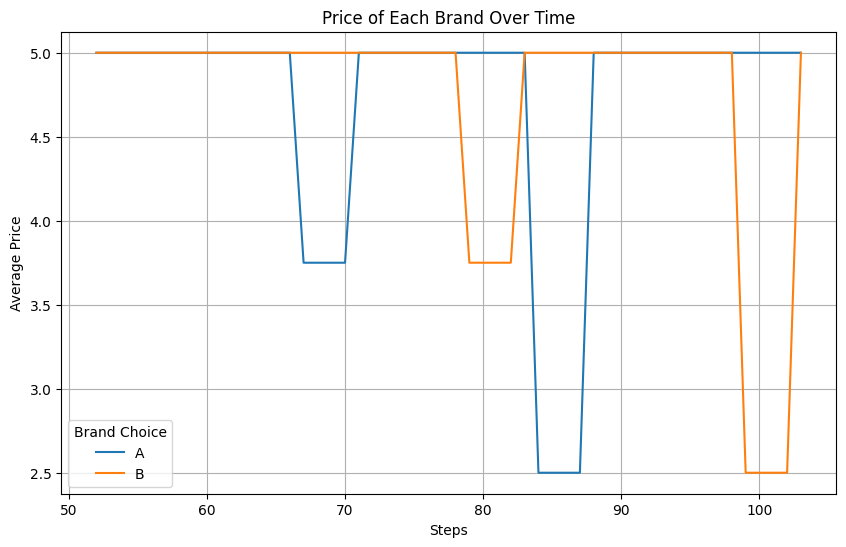

In [18]:
price_over_time = agent_summary_df.groupby(['Step','Brand_Choice'])['Current_Price'].mean().unstack()

plt.figure(figsize=(10,6))
for brand in price_over_time.columns:
    plt.plot(price_over_time.index, price_over_time[brand], label=brand)

plt.title('Price of Each Brand Over Time')
plt.xlabel('Steps')
plt.ylabel('Average Price')
plt.legend(title='Brand Choice')
plt.grid(True)
plt.show()
